In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime

In [164]:
df = pd.read_csv('./HP_CALIB_TEL_CHN_PYRO_A_070325.csv')

MIN_TIME = 0
MAX_TIME = float('inf')
TIME_DELTA = 60*5



In [165]:

date_time= df['DATE1'] +' ' +df['TIME1']
def convert_to_seconds(date_str):
    dt = datetime.strptime(date_str.split('.')[0], "%Y-%m-%d %H:%M:%S")
    return dt.timestamp()

seconds_date_time = date_time.apply(convert_to_seconds)

necessary_df = df[['ACKPOSITIONCH1','ACKPOSITIONCH2','ACKPOSITIONCH3','ACKPOSITIONCH4','ACKPOSITIONCH5','ACKPOSITIONCH6','HYDPRESSURE1','HYDPRESSURE2','HYDPRESSURE3','HYDPRESSURE4','HYDPRESSURE5','HYDPRESSURE6']]
necessary_df = necessary_df.copy()
necessary_df['TIMESTAMP'] = seconds_date_time


print("Before groupby timestamp : ",len(necessary_df))


DATA = {}
for index, row in necessary_df.iterrows():
    pos1,pos2,pos3,pos4,pos5,pos6,pressure1,pressure2,pressure3,pressure4,pressure5,pressure6,timestamp = row
    timestamp = int(timestamp/TIME_DELTA)
    
    if timestamp not in DATA:
        DATA[timestamp] = []
        
    avg_position = (pos1 + pos2 + pos3 + pos4 + pos5+pos6)/6
    avg_pressure = (pressure1 + pressure2 + pressure3 + pressure4 + pressure5 + pressure6)/6
    DATA[timestamp].append([pos1,pos2,pos3,pos4,pos5,pos6,pressure1,pressure2,pressure3,pressure4,pressure5,pressure6,avg_position,avg_pressure])
    



avg_len = 0
count = 0
NEW_DATA = {}
for timestamp in DATA:
    avg_len += len(DATA[timestamp])
    count+=1
    avg_point = [0]*len(DATA[timestamp][0])
    for point in DATA[timestamp]:
        for i in range(len(point)):
            avg_point[i]+=point[i]
    
    for i in range(len(avg_point)):
        avg_point[i]=avg_point[i] / len(DATA[timestamp])

    NEW_DATA[timestamp] = avg_point
    
print("Average group length : ",avg_len/count)
print("After groupby timestamp : ",len(NEW_DATA))


# for timestamp in NEW_DATA:
#     print(timestamp,NEW_DATA[timestamp])

Before groupby timestamp :  16394
Average group length :  420.35897435897436
After groupby timestamp :  39


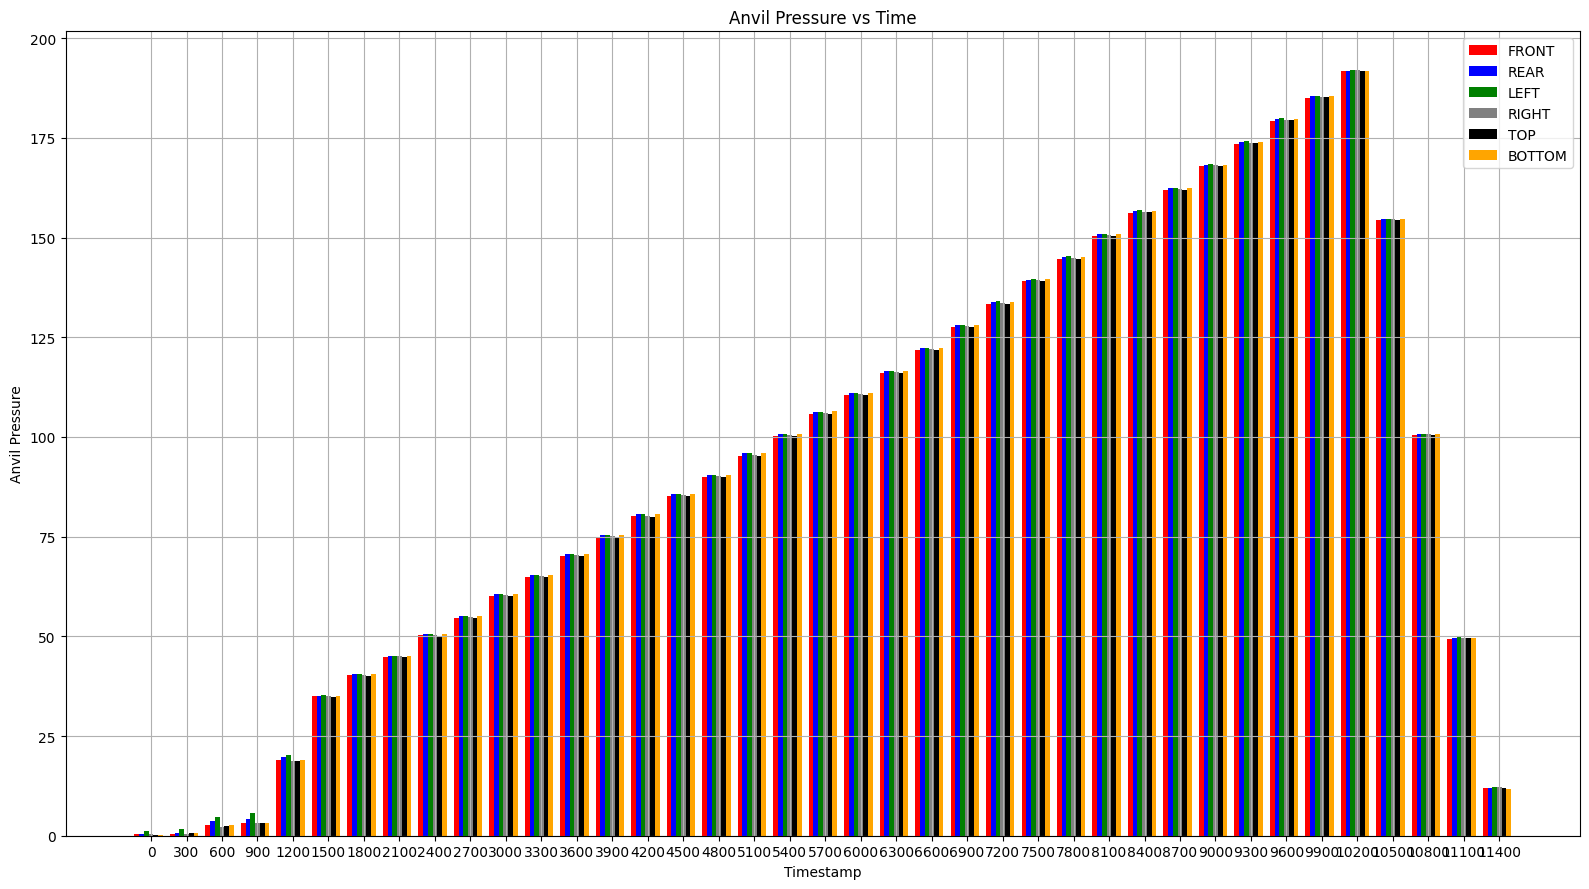

In [166]:
BAR_COLOR = {
            "FRONT" : 'red',
            "REAR"  : 'blue',
            "LEFT"  : 'green',
            "RIGHT" : 'gray',
            "TOP"   : "black",
            "BOTTOM" : 'orange'
        }


data = {
    'Category': [],
    'FRONT' : [],
    'REAR' : [],
    'LEFT' : [],
    'RIGHT' : [],
    'TOP' : [],
    'BOTTOM' : [],
}



START_TIME = 0
for i,timestamp in enumerate(NEW_DATA):
    current_time = START_TIME + i*TIME_DELTA
    
    if(MIN_TIME <= current_time <= MAX_TIME):
        data['Category'].append(current_time)
    else:
        continue
    pos1,pos2,pos3,pos4,pos5,pos6,pressure1,pressure2,pressure3,pressure4,pressure5,pressure6,avg_position,avg_pressure = NEW_DATA[timestamp]
    data['FRONT'].append(pressure1)
    data['REAR'].append(pressure2)
    data['LEFT'].append(pressure3)
    data['RIGHT'].append(pressure4)
    data['TOP'].append(pressure5)
    data['BOTTOM'].append(pressure6)

    

df = pd.DataFrame(data)
categories = df['Category']

groups = df.columns[1:]

x = np.arange(len(categories))
width = 0.8 / len(groups)


fig, ax = plt.subplots(figsize=(16, 9))
for i, group in enumerate(groups):
    color = BAR_COLOR[group]
    ax.bar(x + (i - len(groups) / 2) * width, df[group], width, label=group,color=color)

ax.set_xlabel('Timestamp')
ax.set_ylabel('Anvil Pressure')
ax.set_title(f'Anvil Pressure vs Time')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()

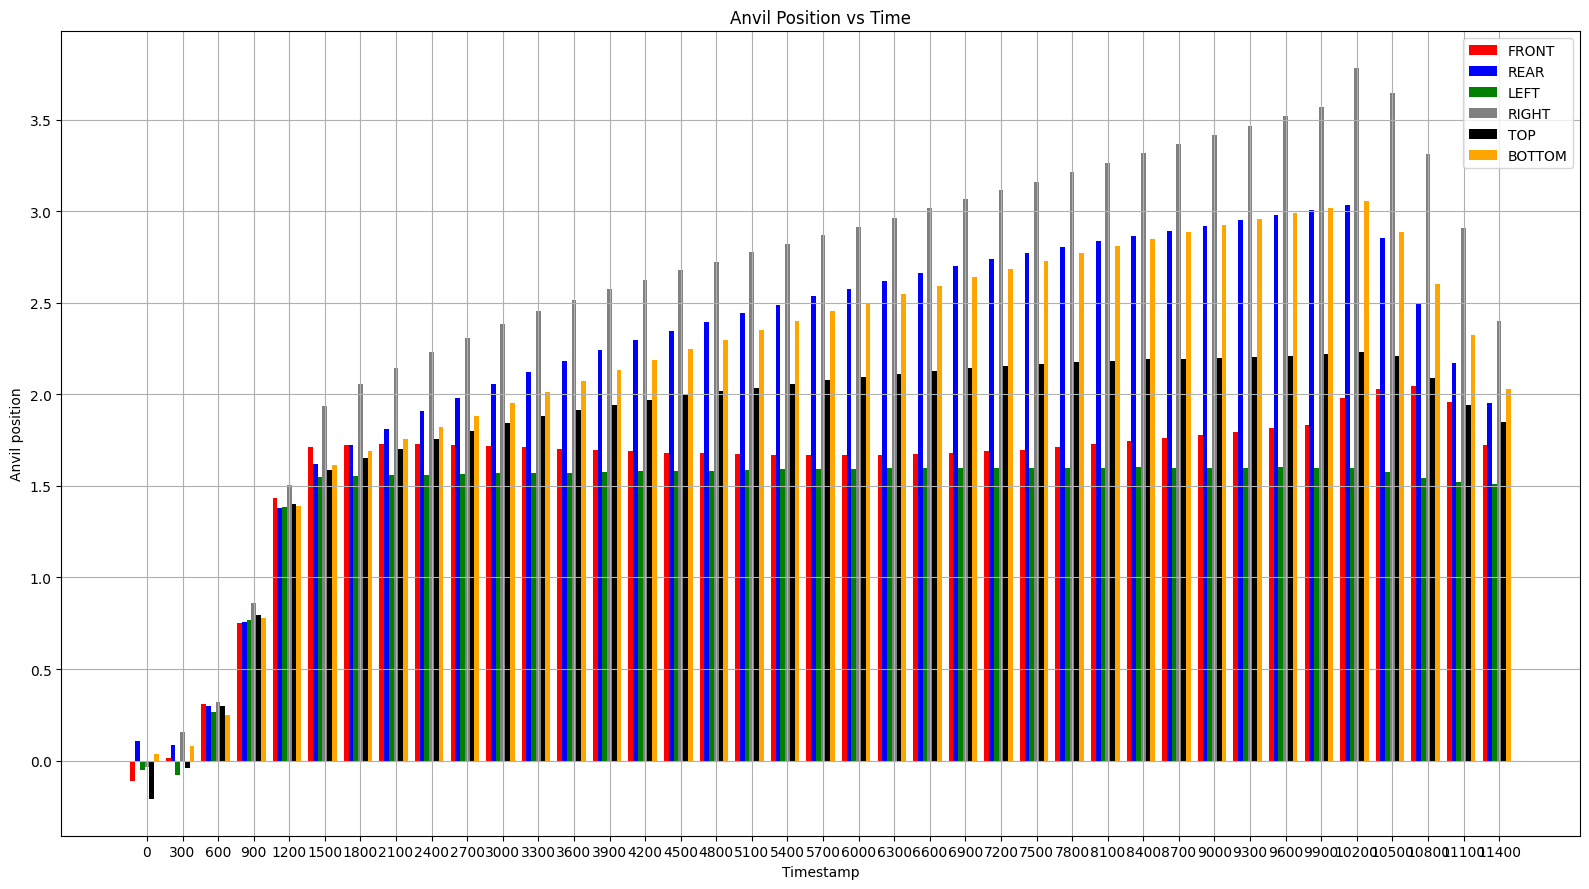

In [167]:

BAR_COLOR = {
            "FRONT" : 'red',
            "REAR"  : 'blue',
            "LEFT"  : 'green',
            "RIGHT" : 'gray',
            "TOP"   : "black",
            "BOTTOM" : 'orange'
        }


data = {
    'Category': [],
    'FRONT' : [],
    'REAR' : [],
    'LEFT' : [],
    'RIGHT' : [],
    'TOP' : [],
    'BOTTOM' : [],
}

START_TIME = 0

for i,timestamp in enumerate(NEW_DATA):
    current_time = START_TIME + i*TIME_DELTA
    if(MIN_TIME <= current_time <= MAX_TIME):
        data['Category'].append(current_time)
    else:
        continue
    pos1,pos2,pos3,pos4,pos5,pos6,pressure1,pressure2,pressure3,pressure4,pressure5,pressure6,avg_position,avg_pressure = NEW_DATA[timestamp]
    data['FRONT'].append(pos1)
    data['REAR'].append(pos2)
    data['LEFT'].append(pos3)
    data['RIGHT'].append(pos4)
    data['TOP'].append(pos5)
    data['BOTTOM'].append(pos6)

    
df = pd.DataFrame(data)
categories = df['Category']

groups = df.columns[1:]

x = np.arange(len(categories))
width = 0.8 / len(groups)


fig, ax = plt.subplots(figsize=(16, 9))
for i, group in enumerate(groups):
    color = BAR_COLOR[group]
    ax.bar(x + (i - len(groups) / 2) * width, df[group], width, label=group,color=color)

ax.set_xlabel('Timestamp')
ax.set_ylabel('Anvil position')
ax.set_title(f'Anvil Position vs Time')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

plt.grid(True)
plt.tight_layout()
plt.show()